## DAV 6150 Module 8

### - individually completed by Qi Sun

***

## Introduction:


The purpose of this study is to predict if the mortgage application will be denied (dependent variable). The data was collected by Federal Reserve Bank of Boston from 1997-1998. This dataset is comprised of 2381 observations. 

I'll use KNN and SVM to create different models that can predict a class (denied/not denied) based on the features. 


**Variables:**

| Variable Name | Description |
| --- | --- |
| dir | debt payments to total income ratio |
| hir | housing expenses to income ratio |
| lvr | ratio of size of loan to assessed value of property |
| ccs | consumer credit score from 1 to 6 (a low value being a good score) |
| mcs | mortgage credit score from 1 to 4 (a low value being a good score) |
| pbcr | public bad credit record ? |
| dmi | denied mortgage insurance ? |
| self | self employed ? |
| single | is the applicant single ?|
| uria | 1989 Massachusetts unemployment rate in the applicant's industry |
| condominium | is unit a condominium ? (was called comdominiom in version 0.2-9 and earlier versions of the package) |
| black | is the applicant black ? |
| deny (dependent variable) | mortgage application denied ? |


For the column 'black', we'll use African American for this column in this study.


**Domain Knowledge:**


All features below could be the factors of the denied mortgage:

1. debt-to-income ratio (**dir**) is all the monthly debt payments divided by the gross monthly income. 

2. housing expenses to income ratio (**hir**) is the percentage of the gross monthly income devoted to housing expenses. The lender will likely deny the loan application because applicant monthly expenses for housing and various debts are too high as compared to applicant income.
https://www.quickenloans.com/mortgage-glossary/housing-expense-ratio


3. loan-to-value (**lvr**) ratio is an assessment of lending risk that financial institutions and other lenders examine before approving a mortgage. Typically, loan assessments with high loan-to-value ratios are considered higher risk loans. 
https://www.thebalance.com/loan-to-value-ratio-315629


4. consumer credit score (**ccs**) is one of the most important factors lenders consider when people apply for a mortgage. It is the #1 reason a mortgage gets denied.
https://www.bankrate.com/mortgages/how-your-credit-score-affects-your-mortgage-rate/


5. public bad credit record (**pbcr**) - public record appears on the credit report. Negative public records can include --tax liens, judgments, bankruptcies--that provide insight into applicant financial status and obligations. The lender will likely deny the mortgage application due to the bad public credit record.
https://www.usa.gov/credit-reports


6. denied mortgage insurance (**dmi**): borrowers making a down payment of less than 20 percent of the purchase price of the home will need to pay for mortgage insurance. Mortgage insurance can be denied due to a large collection account. If the mortgage insurance get denied, the only option for mortgage applicant is to put 20% down. 


7. is self employed (**self**)? for the self employed, it can be difficult to get a mortgage because the applicant may not have tax returns, W-2s, and paycheck stubs to prove the full amount.


8. is the applicant single (**single**)? because single mortgage applicants rely on one salary and one credit profile in order to secure a loan, getting through the underwriting process can be a bit trickier
https://www.investopedia.com/articles/investing/010717/buying-house-single-income.asp


9. **uria** is the probability of unemployment. With unemployment rising, the probability of a borrower could fall behind on their mortgages. 


10. is unit a condominium (**condominium**)? Appraisers divide condos into additional categories, which can affect mortgage approval and financing costs. Typically, lenders consider high-rise buildings bigger risks than shorter projects.
https://themortgagereports.com/24008/townhome-condo-how-your-property-type-affects-your-home-loan-approval


11. is the applicant black? Black applicants for a conventional mortgage are denied at more than twice the rate as white applicants.
https://www.zillow.com/research/black-white-mortgage-denials-19616/


According to Home Mortgage Disclosure Act data released by CoreLogic, top 8 reasons for denying mortgage applicantions include high debt-to-income (dir) ratios, low credit scores (ccs), Loan-to-value (lvr) ratio is too high / appraisal came back low, insufficient cash for down payment, denied mortgage insurance (dmi), credit application incomplete, unreliable information, and employment history.
https://themortgagereports.com/56676/top-two-reasons-mortgage-applications-denied-how-to-avoid-them

**Model:**

I'll use knn and SVM to build models, and tune models using `GridSearchCV` to improve the model. Lastly, I'll use `SHAP` to rank the feature importance for the final selected model.


***

In [3]:
# Importing required libraries.
import pandas as pd
import numpy as np

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve


### Step 1: Load data 

`.head()` returns the first 5 rows of the dataset. 


In [4]:
# read data from Github
df = pd.read_csv("https://raw.githubusercontent.com/susanqisun/DAV-6150/master/assignments/M7/M7_Data.csv")

# To display the top 5 rows
df.head()


,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


***
### Step 2: Exploratory Data Analysis

#### 1. Data description:
`.shape` returns the number of rows by the number of columns for the dataset. My output was (2381, 14), meaning the dataset has 2381 rows and 14 columns.

`.nunique(axis=0)` returns the number of unique values for each variable.

`.describe()` summarizes the count, mean, standard deviation, min, and max for numeric variables. 

`.isnull().sum()` returns the columns and the number of missing values.

In [5]:
print(df.shape)
print(list(df.columns))

(2381, 14)
['Unnamed: 0', 'dir', 'hir', 'lvr', 'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'uria', 'comdominiom', 'black', 'deny']


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2381.0,1191.000000,687.479818,1.00,596.00000,1191.000000,1786.000000,2381.00
dir,2381.0,0.330814,0.107235,0.00,0.28000,0.330000,0.370000,3.00
hir,2381.0,0.255346,0.096635,0.00,0.21400,0.260000,0.298800,3.00
lvr,2381.0,0.737760,0.178715,0.02,0.65285,0.779412,0.868421,1.95
ccs,2381.0,2.116387,1.666370,1.00,1.00000,1.000000,2.000000,6.00
mcs,2381.0,1.721008,0.537169,1.00,1.00000,2.000000,2.000000,4.00
uria,2381.0,3.774496,2.026636,1.80,3.10000,3.200000,3.900000,10.60
comdominiom,2381.0,0.288114,0.452980,0.00,0.00000,0.000000,1.000000,1.00


In [7]:
#Identify the Data Types
df_info = pd.DataFrame(df.dtypes,columns=['Dtype'])

#Identify the unique values
df_info['Nunique'] = df.nunique()

#check missing values for each column
df_info['MissingValues']=df.isnull().sum()

# Identify the count for each variable
df_info['Count']=df.count()

# Identify the zero values for each variable
df_info['ZeroValues']=(df==0).sum()

# how many '?' values
df_info['?Values']=(df=='?').sum()

df_info

/Users/yangyang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,Dtype,Nunique,MissingValues,Count,ZeroValues,?Values
Unnamed: 0,int64,2381,0,2381,0,0
dir,float64,520,0,2381,1,0
hir,float64,501,0,2381,3,0
lvr,float64,1538,0,2381,0,0
ccs,float64,7,0,2381,0,0
mcs,float64,5,0,2381,0,0
pbcr,object,2,1,2380,0,0
dmi,object,2,0,2381,0,0
self,object,2,1,2380,0,0
single,object,2,0,2381,0,0


#### Findings:
>1. The results above showed that the Mortgage dataset includes 2381 observations and 14 columns/variables. The independent variables include integer 64, float 64 and object data types, the dependent/response (deny) variable is string (yes/no) data type also known as an object.
2. There is one missing value in 'pbcr' and one missing value in 'self'. 
3. The categorical variables are pbcr, dmi, self, single, black, and deny (dependent variable).
4. The numerical variables are Unnamed: 0, dir, hir, lvr, ccs, mcs, uria, and comdominiom.
5. The column of 'Unnamed: 0' is meaningless in this dataset, and I'll delete this column later.
6. The variable of 'comdominiom' has two values (0 and 1), which indicates the mortgage is for condo or not. 


#### 2. Dropping irrelevant column

In [8]:
# drop 'Unnamed: 0'
df02 = df.drop(['Unnamed: 0'], axis=1)

#### 3. Check distribution

**3.1 Check distribution of numerical variables**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110522a10>,
      dtype=object)

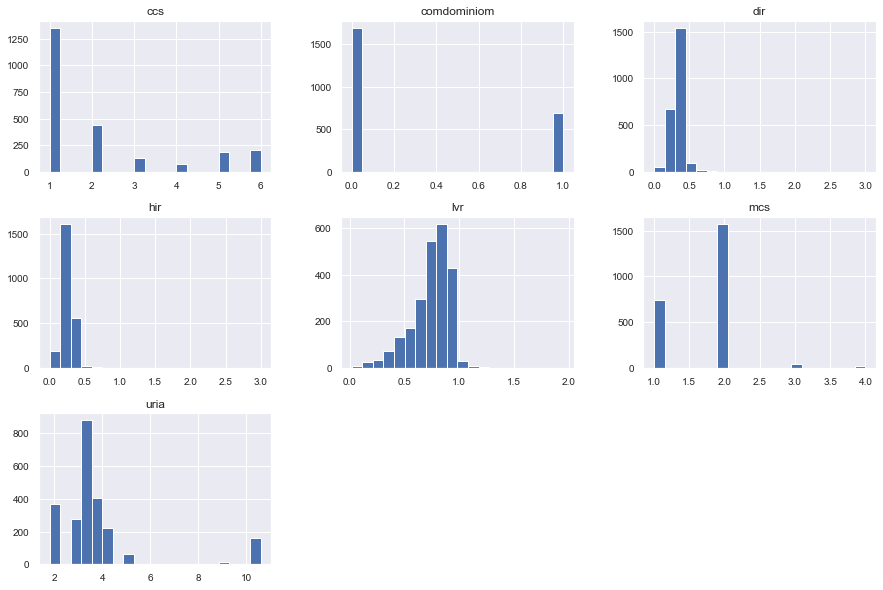

In [9]:
# Distributions for each of numerical variables.
df02.hist(figsize=(15, 10), bins=20, xlabelsize=10, ylabelsize=10)


**3.2 Check distribution of categorical variables**

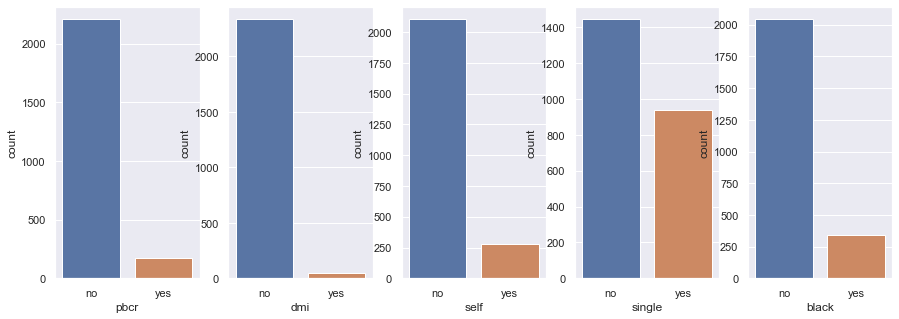

In [10]:
categorical_columns = ['pbcr', 'dmi', 'self', 'single', 'black']

# create the bar chart for each categorical columns
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    sns.countplot(df02[variable], ax=subplot)

**3.3 Check distribution of dependent variable**

Dependent variable: deny - the mortgage application denied? (binary: '1','0')

In [11]:
df02['deny'].value_counts()


no     2096
yes     285
Name: deny, dtype: int64

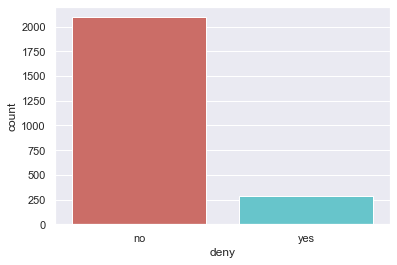

In [12]:
sns.countplot(x='deny',data=df02, palette='hls')
plt.show()

In [13]:
count_no_sub = len(df02[df02['deny']=='no'])
count_sub = len(df02[df02['deny']=='yes'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no denied (approved) is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of denied", pct_of_sub*100)

percentage of no denied (approved) is 88.03023939521209
percentage of denied 11.969760604787904


#### Findings:
>1. Our classes are imbalanced, and the ratio of no-denied to denied instances is 88:12. I'll balance the classes later.
>2. From the distribution histograms above, all variables are not normal distribution.
>3. From the countplot of categorical variables, there are more cases with no public bad credit record, no denied mortgage insurance, not self employed, not a single, and not a black.
>4. All categorical variables have two values - no and yes. There's no outlier.

#### 4. Detect outliers


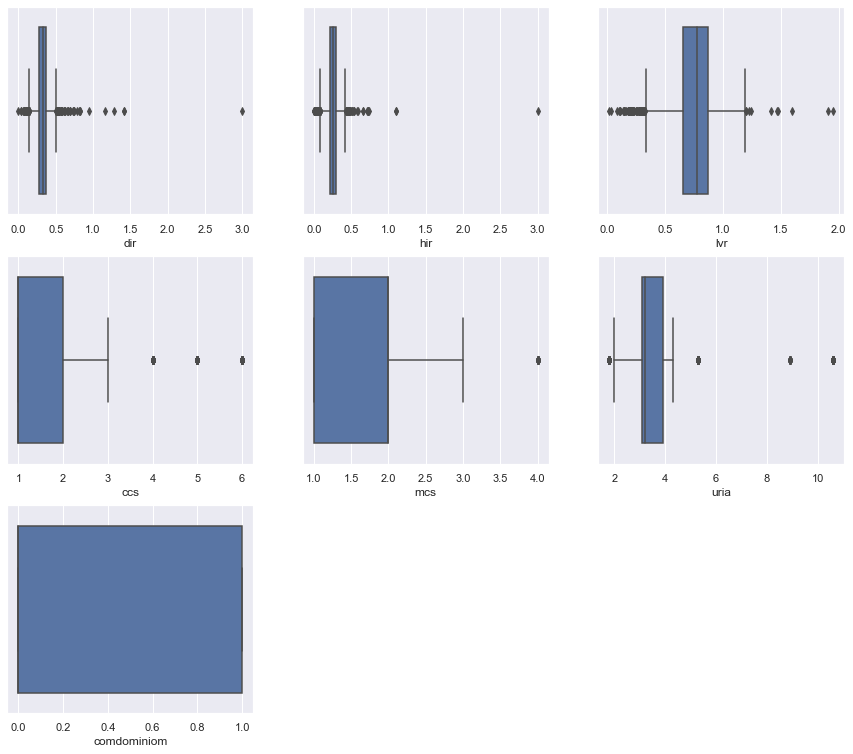

In [14]:
numerical_columns = ['dir', 'hir', 'lvr', 'ccs', 'mcs', 'uria', 'comdominiom']

plt.figure(figsize=(15,13))

h=1
columns=df02[numerical_columns].columns.tolist()
for i in columns:   #for each column in the dataframe except INDEX and TARGET
    plt.subplot(3,3,h) 
    sns.boxplot(x=i,data=df02)
    h=h+1 #add 1 to go to the next subplot space

#show results
plt.show()

#### Findings:
>1. For the variable of 'comdominiom', there are only two values - 0 (no) and 1 (yes). This variable should be categorical. 
2. For other six numerical variables, all of them have outliers. Since this study is to analyze the factors that can predict the denied mortgage, all outliers coule be useful in this case.

#### 5. Check  the correlation bewteen the numerical variables.

Text(0.5, 1.0, 'Figure: Correlations')

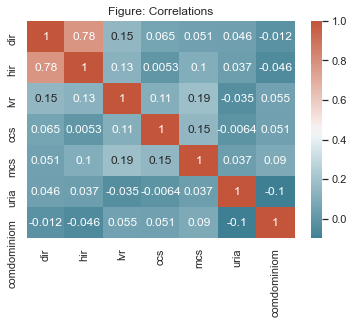

In [15]:
corr = df02.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Figure: Correlations')


For the original dataset, there's no correlation coefficient greater than 0.8. I'll use an absolute correlation coefficient of >0.7 among two or more predictors to indicate the presence of multicollinearity.

***

### Step 3: Data Preparation

#### 1. Handle the missing values

There is one missing value in 'pbcr' and one missing value in 'self'. Since the number is very small, we'll remove the rows with missing values. 


In [16]:
# make a copy
df03 = df02.copy()
print(df02.shape)

(2381, 13)


In [17]:
# drop rows with missing values
df03.dropna(inplace=True)
print(df03.shape)

(2380, 13)


In [18]:
# check the missing
df03.isnull().sum()

dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           0
dmi            0
self           0
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

Only one row has been removed from the dataset.

#### 2. Correct data format of 'comdominiom'

The 'comdominiom' column has the value of 0 and 1, meaning no/yes. I'll change the data type of this column.

In [19]:
# change column name
df04 = df03.rename(columns={'comdominiom': 'condo', 'black': 'African_American'})

# change data type
df04[['condo']] = df04[['condo']].astype('str')

df04.dtypes

dir                 float64
hir                 float64
lvr                 float64
ccs                 float64
mcs                 float64
pbcr                 object
dmi                  object
self                 object
single               object
uria                float64
condo                object
African_American     object
deny                 object
dtype: object

#### Results:
>1. There are 6 string independent variables and 6 numerical independent variables.
>2. The dependent variable 'deny' is string. 

#### 3. Create dummy for dependent variable 

Since I'll perform a binary logistic regression, the dependent variable should be a 0-or-1 variable. I'll use 0 for the 'no' value and use 1 for the 'yes' value in the column of 'deny'.

In [20]:
df04['IsDeny'] = (df04['deny'] == 'yes').astype(int)


In [21]:
df04['IsDeny'].value_counts()

0    2095
1     285
Name: IsDeny, dtype: int64

#### 4. Create dummy for string variables

Next, I'll create dummy indicators for the categorical variables - African_American, condo, single, self, dmi, and pbcr. For example, the new dummy variable 'IsAfricanAmerican' contains a '1' if the 'African_American' value for an applicant is 'yes' and a '0' otherwise.

In [22]:
df05 = df04.copy()

In [23]:
# create a dummy variable 
df05['IsAfricanAmerican'] = (df05['African_American'] == 'yes').astype(int)
df05['IsCondo'] = (df05['condo'] == '1').astype(int)
df05['IsSingle'] = (df05['single'] == 'yes').astype(int)
df05['IsSelf'] = (df05['self'] == 'yes').astype(int)
df05['IsDeniedMI'] = (df05['dmi'] == 'yes').astype(int)
df05['IsBadCredit'] = (df05['pbcr'] == 'yes').astype(int)
df05.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,African_American,deny,IsDeny,IsAfricanAmerican,IsCondo,IsSingle,IsSelf,IsDeniedMI,IsBadCredit
0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no,0,0,0,0,0,0,0
1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no,0,0,0,1,0,0,0
2,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no,0,0,0,0,0,0,0
3,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no,0,0,0,0,0,0,0
4,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no,0,0,0,0,0,0,0


#### 5. Set up new data set

In [24]:
new_variables = ['dir', 'hir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI',
       'uria', 'IsAfricanAmerican', 'IsDeny',
       'IsCondo', 'IsSingle', 'IsSelf']

df06 = df05[new_variables]
df06.head()

,dir,hir,lvr,ccs,mcs,IsBadCredit,IsDeniedMI,uria,IsAfricanAmerican,IsDeny,IsCondo,IsSingle,IsSelf
0,0.221,0.221,0.800000,5.0,2.0,0,0,3.9,0,0,0,0,0
1,0.265,0.265,0.921875,2.0,2.0,0,0,3.2,0,0,0,1,0
2,0.372,0.248,0.920398,1.0,2.0,0,0,3.2,0,0,0,0,0
3,0.320,0.250,0.860465,1.0,2.0,0,0,4.3,0,0,0,0,0
4,0.360,0.350,0.600000,1.0,1.0,0,0,3.2,0,0,0,0,0



***

### Step 4: Prepped Data Review

#### 1. Check the relationship between independent variables and the dependent variable


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

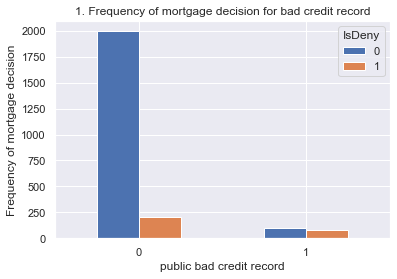

In [25]:
# IsBadCredit vs. deny
pd.crosstab(df06.IsBadCredit,df06.IsDeny).plot(kind='bar')
plt.title('1. Frequency of mortgage decision for bad credit record')
plt.xlabel('public bad credit record')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

The frequency of mortgage application decision depends a great deal on the public credit record. Thus, it can be a good predictor of the outcome variable.


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

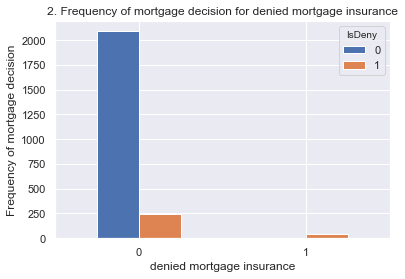

In [24]:
# IsDeniedMI vs. deny
pd.crosstab(df06.IsDeniedMI,df06.IsDeny).plot(kind='bar')
plt.title('2. Frequency of mortgage decision for denied mortgage insurance')
plt.xlabel('denied mortgage insurance')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

Mortgage insurance seems a good predictor of the outcome variable.

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

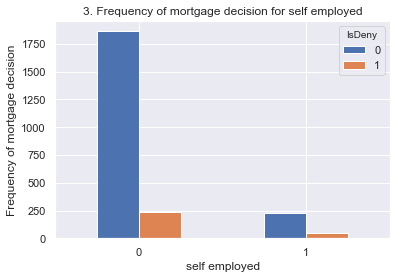

In [25]:
# IsSelf vs. deny
pd.crosstab(df06.IsSelf,df06.IsDeny).plot(kind='bar')
plt.title('3. Frequency of mortgage decision for self employed')
plt.xlabel('self employed')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

Self employed or not might be a good predictor of the outcome variable.



(array([0, 1]), <a list of 2 Text major ticklabel objects>)

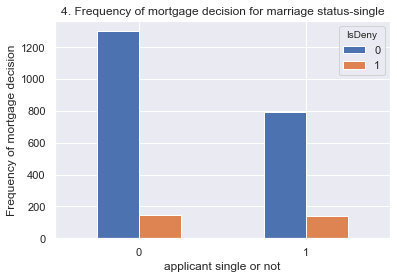

In [26]:
# IsSingle vs. deny
pd.crosstab(df06.IsSingle,df06.IsDeny).plot(kind='bar')
plt.title('4. Frequency of mortgage decision for marriage status-single')
plt.xlabel('applicant single or not')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

Marriage status might be a good predictor of the outcome variable.



(array([0, 1]), <a list of 2 Text major ticklabel objects>)

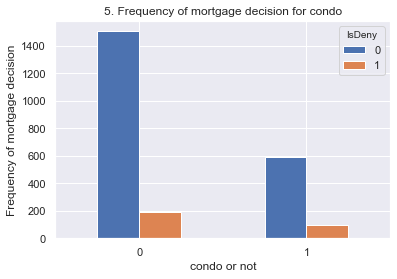

In [27]:
# IsCondo vs. deny
pd.crosstab(df06.IsCondo,df06.IsDeny).plot(kind='bar')
plt.title('5. Frequency of mortgage decision for condo')
plt.xlabel('condo or not')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

Property type (condo/not condo) might be a good predictor of the outcome variable.


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

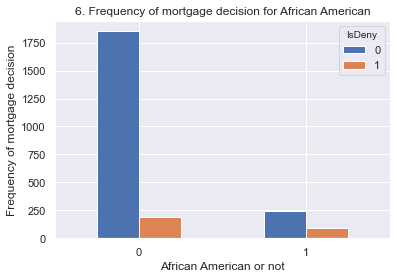

In [28]:
# IsAfricanAmerican vs. deny
pd.crosstab(df06.IsAfricanAmerican,df06.IsDeny).plot(kind='bar')
plt.title('6. Frequency of mortgage decision for African American')
plt.xlabel('African American or not')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

African American or not might be a good predictor of the outcome variable.


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

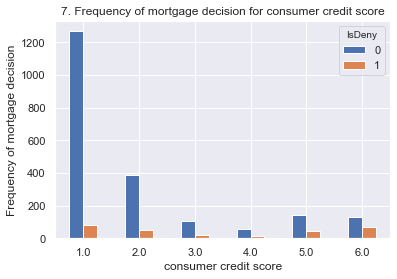

In [29]:
# ccs vd. deny
pd.crosstab(df06.ccs,df06.IsDeny).plot(kind='bar')
plt.title('7. Frequency of mortgage decision for consumer credit score')
plt.xlabel('consumer credit score')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

Consumer credit score might be a good predictor of the outcome variable.



(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

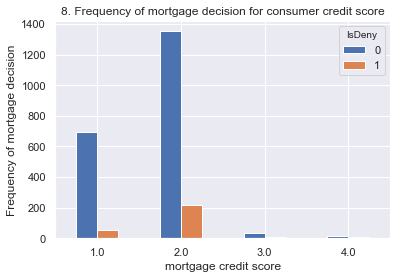

In [30]:
# mcs vd. deny
pd.crosstab(df06.mcs,df06.IsDeny).plot(kind='bar')
plt.title('8. Frequency of mortgage decision for consumer credit score')
plt.xlabel('mortgage credit score')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

Mortgage credit score might be a good predictor of the outcome variable.



[]

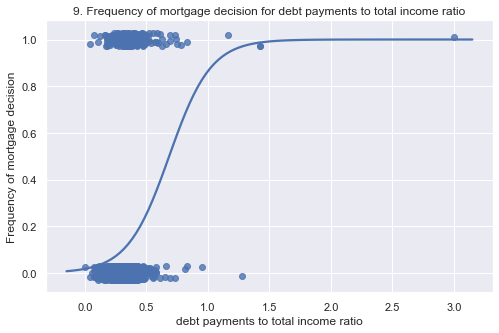

In [31]:
# dir vs. deny
plt.figure(figsize=(8, 5))
sns.regplot(x='dir', y='IsDeny', data=df06, y_jitter=0.03, logistic=True, ci=None)
plt.title('9. Frequency of mortgage decision for debt payments to total income ratio')
plt.xlabel('debt payments to total income ratio')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)
plt.plot()


Debt payments to total income ratio might be a good predictor of the outcome variable.



[]

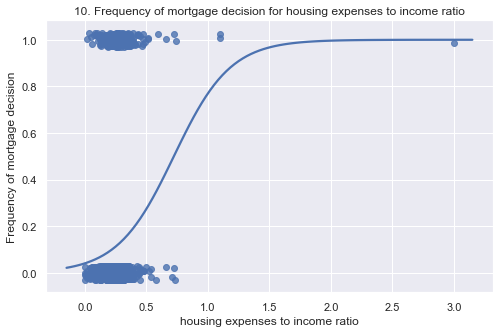

In [32]:
# hir vs. deny
plt.figure(figsize=(8, 5))
sns.regplot(x='hir', y='IsDeny', data=df06, y_jitter=0.03, logistic=True, ci=None)
plt.title('10. Frequency of mortgage decision for housing expenses to income ratio')
plt.xlabel('housing expenses to income ratio')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)
plt.plot()

Housing expenses to income ratio might be a good predictor of the outcome variable.



[]

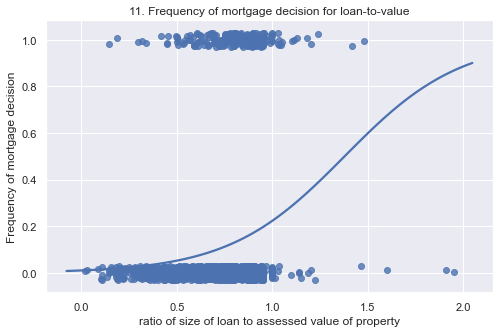

In [33]:
# lvr vs. deny
plt.figure(figsize=(8, 5))
sns.regplot(x='lvr', y='IsDeny', data=df06, y_jitter=0.03, logistic=True, ci=None)
plt.title('11. Frequency of mortgage decision for loan-to-value')
plt.xlabel('ratio of size of loan to assessed value of property')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)
plt.plot()

Ratio of size of loan to assessed value of property might be a good predictor of the outcome. 
The likelihood of a loan being denied increases significantly if the lvr is greater than 0.5 and that very few loan applications are rejected if the lvr is less than 0.5.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

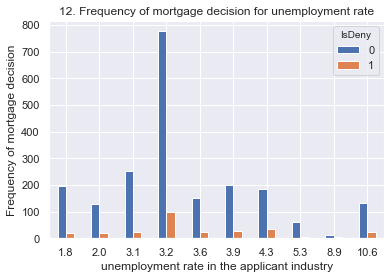

In [34]:
# uria vs. deny
pd.crosstab(df06['uria'].round(1),df06.IsDeny).plot(kind='bar')
plt.title('12. Frequency of mortgage decision for unemployment rate')
plt.xlabel('unemployment rate in the applicant industry')
plt.ylabel('Frequency of mortgage decision')
plt.xticks(rotation=0)

Employment rate in the applicant industry might be a good predictor of the outcome variable.


#### 2. Check correlation and the independence between the independent variables

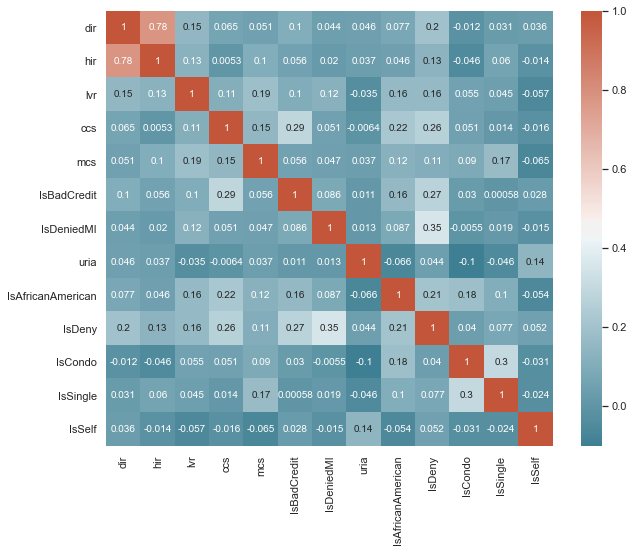

In [35]:
plt.figure(figsize=(10,8))

corr = df06.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))


#### Findings:
>1. There's no feature having the correlation coefficient above 0.8. I'll use an absolute correlation coefficient of >0.7 among two or more predictors indicating the presence of multicollinearity.
>2. The independence between the independent variables is good, because this dataset contains no correlated features. 
>3. The highest correlation coefficient is 0.78, betweeb hir and dir.

***
### Step 5. Feature Selection

The classes of this dataset are imbalanced, and the ratio of no-deny to deny is 88:12. Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance. Before checking feature importance, I need to balance the class distribution and normalize the dataset.

Most feature selection methods can be divided into three major buckets:
* **Filter based**: We specify some metric and based on that filter features. An example of such a metric could be correlation/chi-square.
* **Wrapper-based**: Wrapper methods consider the selection of a set of features as a search problem. Example: Recursive Feature Elimination
* **Embedded**: Embedded methods use algorithms that have built-in feature selection methods. For instance, Lasso and RF have their own feature selection methods.

In my last week's assignment, the Wrapper method (recursive feature elimination) and Embedded method (SelectFromModels) were used for feature selection. For the method of `SelectFromModels`, only three features have been selected. 

Since the requirement of this week's assignment that at least five explanatory variables are required in the model, I'll use different methods for feature selection.

In this study, I'll use Filter method (**coefficient values**) and Wrapper method (**backward elimination**) for kNN and SVM models. 

https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f

https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f



#### 1. Over-sampling using SMOTE

`SMOTE` works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Researchers have found that balancing the data will to better classification models

SMOTE (Synthetic Minority Over-sampling Technique) is a type of over-sampling procedure that is used to correct the imbalances in the groups. This technique creates new data instances of the minority groups by copying existing minority instances and making small changes to them. This makes SMOTE great at amplifying signals that already exist in the minority groups, but won’t create new information for those groups.


In [26]:
# make a copy
df07 = df06.copy()

In [27]:
# Create X and y
X = df07.drop(['IsDeny'], axis=1)
y = df07[['IsDeny']]

In [28]:
# Now split the data into training and testing subsets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# check the results
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (1904, 12) (1904, 1)
Testing dataset shape: (476, 12) (476, 1)


In [29]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
columns = X_train.columns
X_resampled_test,y_resampled_test=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=X_resampled_test,columns=columns )
os_data_y= pd.DataFrame(data=y_resampled_test,columns=['IsDeny'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(X_resampled_test))
print("Number of no deny in oversampled data",len(y_resampled_test[y_resampled_test['IsDeny']==0]))
print("Number of deny",len(y_resampled_test[y_resampled_test['IsDeny']==1]))
print("Proportion of no deny data in oversampled data is ",len(y_resampled_test[y_resampled_test['IsDeny']==0])/len(X_resampled_test))
print("Proportion of deny data in oversampled data is ",len(y_resampled_test[y_resampled_test['IsDeny']==1])/len(X_resampled_test))


length of oversampled data is  3364
Number of no deny in oversampled data 1682
Number of deny 1682
Proportion of no deny data in oversampled data is  0.5
Proportion of deny data in oversampled data is  0.5


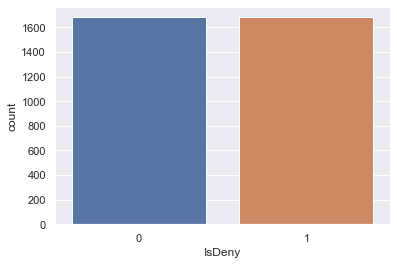

In [30]:
# observe that data has been balanced
sns.countplot(x='IsDeny', data=os_data_y)


**Check the null error rate:**

Null Error Rate is how often you would be wrong if you always predicted the majority class.


In [31]:
# null error rate of balanced dataset
# set up dataset after SMOTE
data_train = pd.concat([os_data_X, os_data_y], axis=1)

# what percentage of the training set denied?
data_train.IsDeny.values.sum() / data_train.shape[0]

0.5

In [32]:
# Null error rate of the original dataset
1 - df06.IsDeny.values.sum() / df06.shape[0]

0.8802521008403361

The null error rate of the imbalanced trianing dataset is 88%, which is great but not reliable since the dataset is imbalanced. After using 'SMOTE' to balance the dataset, the null error rate for the balanced training dataset is reduced from 88% to 50%.


In [36]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train['IsDeny']==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train['IsDeny']==0)))

print('After OverSampling, the shape of train_X: {}'.format(os_data_X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(os_data_y.shape))

print("After OverSampling, counts of label '1': {}".format(sum(os_data_y['IsDeny']==1)))
print("After OverSampling, counts of label '0': {}".format(sum(os_data_y['IsDeny']==0)))

Before OverSampling, counts of label '1': 222
Before OverSampling, counts of label '0': 1682 

After OverSampling, the shape of train_X: (3364, 12)
After OverSampling, the shape of train_y: (3364, 1) 

After OverSampling, counts of label '1': 1682
After OverSampling, counts of label '0': 1682


The training dataset has been banlanced.

#### 2. Standardizing the Variables

Scaling is important in the algorithms such as support vector machines (SVM) and k-nearest neighbors (KNN) where distance between the data points is important. 

I'll use the `StandardScaler()`, `fit_transform` to the train set, and `transform` the test set.

In [37]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# Standardizing the train dataset
os_data_X02 = sc.fit_transform(os_data_X)
scaled_X_train = pd.DataFrame(os_data_X02, columns=os_data_X.columns)
scaled_X_train.head()

,dir,hir,lvr,ccs,mcs,IsBadCredit,IsDeniedMI,uria,IsAfricanAmerican,IsCondo,IsSingle,IsSelf
0,1.938014,1.176849,0.066239,-0.828917,-1.628706,-0.356855,-0.194811,-0.314114,-0.480033,-0.583300,1.245934,3.249637
1,-0.447556,-0.468146,0.771838,1.807325,0.390348,-0.356855,-0.194811,0.012309,-0.480033,-0.583300,1.245934,-0.307727
2,-0.013010,0.233858,-0.146772,-0.828917,0.390348,-0.356855,-0.194811,0.012309,-0.480033,1.714383,1.245934,-0.307727
3,-1.094942,-0.415757,-2.878454,-0.828917,-1.628706,-0.356855,-0.194811,0.198836,-0.480033,-0.583300,-0.802611,-0.307727
4,-0.633790,-0.185248,-0.598970,-0.301668,-1.628706,-0.356855,-0.194811,-0.314114,-0.480033,-0.583300,-0.802611,-0.307727


In [38]:
# Standardizing the test dataset
X_test02 = sc.transform(X_test)
scaled_X_test = pd.DataFrame(X_test02, columns=X_test.columns)

All data have been transformed having a mean of 0 and a standard deviation of 1.

#### 3. Feature Importance - coefficient values

The higher the coefficient, the higher the “importance” of a feature. To set the baseline, the decision was made to select the top eight features. I'll rank features by using coefficient values.

In [39]:
from sklearn.linear_model import LogisticRegression

# logistic regression for feature importance
logreg = LogisticRegression()

# fit the model
logreg.fit(scaled_X_train, os_data_y.values.ravel())

# calculate the coefficients
df_coeff = pd.DataFrame({"Feature":scaled_X_train.columns.tolist(),"Coefficients":logreg.coef_[0]})

df_coeff.iloc[df_coeff['Coefficients'].abs().argsort()[::-1]].reset_index(drop=True)


,Feature,Coefficients
0,dir,0.700698
1,IsDeniedMI,0.637150
2,ccs,0.541704
3,lvr,0.315733
4,IsBadCredit,0.265528
5,mcs,0.247294
6,IsAfricanAmerican,0.220406
7,IsCondo,-0.165879
8,IsSingle,0.127097
9,uria,0.126693


The coefficient values that are greater than 0.2 will be selected for the model. 

There are 7 features selected, they are 'dir, IsDeniedMI, ccs, lvr, IsBadCredit, mcs, IsAfricanAmerican'.



#### 4. Feature Importance - Backward elimination

https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f

Next, I'll use backward elimination for feature selection.

In backward elimination, we start with the full model (including all the independent variables) and then remove the insignificant feature with highest p-value(>significance level). This process repeats again and again until we have the final set of significant features.

In short, the steps involved in backward elimination are as follows: 
* 1. Choose a significance level (e.g. SL = 0.05 with a 95% confidence).
* 2. Fit a full model including all the features.
* 3. Consider the feature with highest p-value. If the p-value > significance level then go to Step 4, otherwise terminate the process.
* 4. Remove the feature which is under consideration.
* 5. Fit a model without this feature. Repeat the entire process from Step 3.


In [93]:
# https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f

def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.Logit(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

I'll use the above function to return a final list of significant features based on p-values through backward elimination.

In [94]:
backward_elimination(scaled_X_train,os_data_y)

Optimization terminated successfully.
         Current function value: 0.541742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.541804
         Iterations 7


['dir',
 'lvr',
 'ccs',
 'mcs',
 'IsBadCredit',
 'IsDeniedMI',
 'uria',
 'IsAfricanAmerican',
 'IsCondo',
 'IsSingle',
 'IsSelf']

#### Findings:
1. From the feature selection method of coefficient values, I got the sorted features by coefficient values. The features with coefficients greater than 0.2 are selected for the model. They are 'dir, IsDeniedMI, ccs, lvr, IsBadCredit, mcs, IsAfricanAmerican'.
2. From the feature selection method of backward elimination, 11 features are statistically significant to the model. They are 'dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf'. And 'hir' was removed. I'll use these 11 features in another model. 



***
### Step 6. KNN + SVM Modeling

First of all, I'll build a model with all features for model comparison. Then, 2 different models will be performed by using different features that are selected from the step of feature selection. I'll use the training dataset to build models.

>* KNN01 = KNN model + full features: ('dir', 'hir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf')

>* KNN02 = KNN model + top 7 features from coefficient values: 'dir, IsDeniedMI, ccs, lvr, IsBadCredit, mcs, IsAfricanAmerican'.

>* KNN03 = KNN model + 11 features with significant p value: 'dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf'. 

>* Pick the best model from knn medles and train the knn Classifier with Hyper-parameter Tuning

>* SVM01 = SVM model + full features: ('dir', 'hir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf')

>* SVM02 = SVM model + top 7 features from coefficient values: 'dir, IsDeniedMI, ccs, lvr, IsBadCredit, mcs, IsAfricanAmerican'. 

>* SVM03 = SVM model + 11 features with significant p value: 'dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf'. 

>* Pick the best model from SVM models and train the Support Vector Classifier with Hyper-parameter Tuning



#### Create a function for model evaluation:

For the training dataset, I'll use **cross-validation** to evaluate models since the training dataset is balaned. I'll use 10-fold cross-validation to see if the accuracy holds up more rigorously.

I'll also perform model evaluation on the test dataset, which has an uneven class distribution. Therefore, accuracy is not a good metric for classification. Based on Professor Topor's lecture notes and below webpages, I'll choose the following metrics for model evaluation. For this study, what I care about are those whose mortgage application were actually denied and can be predicted denied (true negatives).  

https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124


1. Both **F1 score and ROC-AUC score** can be used for class imbalance. 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 
A test with no better accuracy than chance has an AUC of 0.5, and a test with perfect accuracy has an AUC of 1. AUC score means the probability that a randomly selected case will have a higher test result than a randomly selected control.

2. I'm trying to minimize the number of false positives (FP), I'll use **precision** as one of the primary model performance metrics. Precision attempts to answer what proportion of positive identifications was actually correct. The false positives in this study mean the approved mortgage applications from the model should be denied. Therepore, the number of false positives should be minimized in order to reduce the number of those can't pay their mortgage.

3. Choose **Specificity** if I want to cover all true negatives, meaning I don’t want any false alarms, I don’t want any false positives. Specificity tells us what proportion of the negative class got correctly classified. For example, I'll use the selected model to decide whose mortgage application can be approved. False positives here are intolerable. Specifity answers the following question: Of all the people whose mortgage applications were denied, how many of those did the model correctly predict?


In [48]:
def generate_model_report(y_actual, y_predicted):
    cm1 = confusion_matrix(y_actual, y_predicted)
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity: ', specificity1)    
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

In [78]:
# Model Evaluation Using Cross-Validation
def cv_scores (model, X_train, y_train):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print('trainging dataset each cv score:',cv_scores)
    print('Model Mean Accuracy (training datasert):{} '.format(np.mean(cv_scores)))
    

### 1. KNN model01

The knn01 has all 12 features.

In [41]:
#Create KNN Object.
knn01 = KNeighborsClassifier()

#Create x and y variables.
X01 = scaled_X_train
y01 = os_data_y

#fit the model.
knn01.fit(X01, y01.values.ravel())

#Predict test data set.
y_pred01 = knn01.predict(scaled_X_test)


### 2. KNN model02
The second model has 7 features.

In [42]:
#Create KNN Object.
knn02 = KNeighborsClassifier()

#Create x and y variables.
X02 = scaled_X_train[['dir', 'IsDeniedMI', 'ccs', 'lvr', 'IsBadCredit', 'mcs', 'IsAfricanAmerican']]
y02 = os_data_y

scaled_X_test02 = scaled_X_test[['dir', 'IsDeniedMI', 'ccs', 'lvr', 'IsBadCredit', 'mcs', 'IsAfricanAmerican']]

#fit the model.
knn02.fit(X02, y02.values.ravel())

#Predict test data set.
y_pred02 = knn02.predict(scaled_X_test02)


### 3. KNN model03
The third model has 11 features.

In [43]:
#Create KNN Object.
knn03 = KNeighborsClassifier()

#Create x and y variables.
X03 = scaled_X_train[['dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf']]
y03 = os_data_y

scaled_X_test03 = scaled_X_test[['dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf']]

#fit the model.
knn03.fit(X03, y03.values.ravel())

#Predict test data set.
y_pred03 = knn03.predict(scaled_X_test03)


***knn Model evaluation:**

In [80]:
#Checking performance the model with ROC Score.
#Checking performance the model

print("knn_Model 01:")
cv_scores(knn01, X01, y01.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred01))
generate_model_report(y_test, y_pred01)
print("-------------------------------------------")

print("knn_Model 02:")
cv_scores(knn02, X02, y02.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred02))
generate_model_report(y_test, y_pred02)
print("-------------------------------------------")

print("knn_Model 03:")
cv_scores(knn03, X03, y03.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred03))
generate_model_report(y_test, y_pred03)
print("-------------------------------------------")


knn_Model 01:
trainging dataset each cv score: [0.8410104  0.79494799 0.83506686 0.82466568 0.81994048]
Model Mean Accuracy (training datasert):0.8231262824594919 
roc_auc_score= 0.7300242130750605
Specificity:  0.7142857142857143
Precision =  0.3
F1 Score =  0.4225352112676056
-------------------------------------------
knn_Model 02:
trainging dataset each cv score: [0.79643388 0.78008915 0.76077266 0.78454681 0.77083333]
Model Mean Accuracy (training datasert):0.7785351659237245 
roc_auc_score= 0.6879203658864675
Specificity:  0.6349206349206349
Precision =  0.272108843537415
F1 Score =  0.38095238095238093
-------------------------------------------
knn_Model 03:
trainging dataset each cv score: [0.82763744 0.82912333 0.81723626 0.80089153 0.8110119 ]
Model Mean Accuracy (training datasert):0.8171800926908654 
roc_auc_score= 0.7208770513855259
Specificity:  0.6984126984126984
Precision =  0.29333333333333333
F1 Score =  0.4131455399061033
-------------------------------------------


#### Results:

The knn model01 has the highest model mean accuracy (training dataset), roc_auc_score, Specificity, Precision and F1 score. However, I prefer the model03. The knn model01 is better than the model03, but the difference is very little. The knn model03 deleted the 'hir' feature, which has the least coefficient, has a high correlation coefficient r (0.78) with the feature of 'dir' and is not statistically significant to the model. Therefore, for the knn model, I'll choose model03. Next, I'll tune the hyperparameters of the model03 to see if I can a better model.


### 4. Hypertuning knn model parameters using `GridSearchCV`

Here are the default values for knn: `sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)`

GridSearchCV works by training the model multiple times on a range of parameters that I specify. That way, I can test the model with each parameter and figure out the optimal values to get the best accuracy results.

The default values were just used for the above knn models. I'll tune the following hyperparameters in this step:

**n_neighbors** int, default=5
Number of neighbors to use by default for kneighbors queries.

**p** int, default=2
Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. 


In [45]:
# https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

#List Hyperparameters that we want to tune.
grid_params = {
    'n_neighbors':np.arange(1, 25),
    'p': [1,2]
}

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(knn_2, grid_params, cv=10)

#Fit the model
best_model = clf.fit(X03, y03.values.ravel())

#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best p: 1
Best n_neighbors: 1


In [50]:
print(best_model.best_estimator_)

KNeighborsClassifier(n_neighbors=1, p=1)


In [83]:
#check mean score for the top performing value of n_neighbors
best_model.best_score_

0.8567189487070793

We can see that 1 is the optimal value for ‘n_neighbors’ and 1 (manhattan_distance) is the optimal value for 'p'. I used the `best_score_` function to check the accuracy of the adjusted model when ‘n_neighbors’ is 1 and 'p' is 1. The ‘best_score_’ outputs the mean accuracy of the scores obtained through cross-validation.

***Compare the adjusted model with the original model:**

In [82]:
#Predict test data set using the adjusted model.
y_pred03_new = best_model.predict(scaled_X_test03)

print("01.adjusted knn_Model (n_neighbors=1, p=1 -manhattan_distance):")
print('top performing n_neighbors value: ',best_model.best_score_)
print('roc_auc_score=', roc_auc_score(y_test, y_pred03_new))
generate_model_report(y_test, y_pred03_new)
print("-------------------------------------------")
print("02.original knn_Model:")
cv_scores(knn03, X03, y03.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred03))
generate_model_report(y_test, y_pred03)
cv_scores(knn03, X03, y03.values.ravel())
print("-------------------------------------------")

01.adjusted knn_Model (n_neighbors=1, p=1 -manhattan_distance):
top performing n_neighbors value:  0.8567189487070793
roc_auc_score= 0.6358622545063224
Specificity:  0.49206349206349204
Precision =  0.2540983606557377
F1 Score =  0.3351351351351351
-------------------------------------------
02.original knn_Model:
trainging dataset each cv score: [0.82763744 0.82912333 0.81723626 0.80089153 0.8110119 ]
Model Mean Accuracy (training datasert):0.8171800926908654 
roc_auc_score= 0.7208770513855259
Specificity:  0.6984126984126984
Precision =  0.29333333333333333
F1 Score =  0.4131455399061033
trainging dataset each cv score: [0.82763744 0.82912333 0.81723626 0.80089153 0.8110119 ]
Model Mean Accuracy (training datasert):0.8171800926908654 
-------------------------------------------


#### Results:
By using grid search to find the optimal parameter for the KNN model, I have improved the knn model accuracy by almost 4%. However, the performance of prediction on the imbalanced test dataset is worse than the original model. In order to get the best performance, if I use the adjusted knn model in an imbalanced dataset, I need to balance the data before building the knn model. Finally, the best knn model is the adjusted one with 11 features and parameters of manhattan_distance and n_neighbors=1. 


### 5. SVM model01

The SVM model01 has 12 features.

In [52]:

# train the model on train set 
SVM_model01 = SVC() 

#Create x and y variables.
X01 = scaled_X_train
y01 = os_data_y

#fit the model
SVM_model01.fit(X01, y01.values.ravel()) 

#Predict test data set.
y_pred04 = SVM_model01.predict(scaled_X_test)

### 6. SVM model02
The second model has 7 features.

In [53]:
# train the model on train set 
SVM_model02 = SVC() 

#Create x and y variables.
X02 = scaled_X_train[['dir', 'IsDeniedMI', 'ccs', 'lvr', 'IsBadCredit', 'mcs', 'IsAfricanAmerican']]
y02 = os_data_y

scaled_X_test02 = scaled_X_test[['dir', 'IsDeniedMI', 'ccs', 'lvr', 'IsBadCredit', 'mcs', 'IsAfricanAmerican']]

#fit the model
SVM_model02.fit(X02, y02.values.ravel()) 

#Predict test data set.
y_pred05 = SVM_model02.predict(scaled_X_test02)


### 7. SVM model03
The third model has 11 features.

In [54]:
# train the model on train set 
SVM_model03 = SVC() 

#Create x and y variables.
X03 = scaled_X_train[['dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf']]
y03 = os_data_y

scaled_X_test03 = scaled_X_test[['dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', 'IsSelf']]

#fit the model
SVM_model03.fit(X03, y03.values.ravel()) 

#Predict test data set.
y_pred06 = SVM_model03.predict(scaled_X_test03)


***SVM Model evaluation:**

In [84]:
#Checking performance the model with ROC Score.
#Checking performance the model

print("SVM_Model 01:")
cv_scores(SVM_model01, X01, y01.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred04))
generate_model_report(y_test, y_pred04)
print("-------------------------------------------")

print("SVM_Model 02:")
cv_scores(SVM_model02, X02, y02.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred05))
generate_model_report(y_test, y_pred05)
print("-------------------------------------------")

print("SVM_Model 03:")
cv_scores(SVM_model03, X03, y03.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred06))
generate_model_report(y_test, y_pred06)
print("-------------------------------------------")

SVM_Model 01:
trainging dataset each cv score: [0.78008915 0.76374443 0.78454681 0.75334324 0.80357143]
Model Mean Accuracy (training datasert):0.777059010825727 
roc_auc_score= 0.7309658326607479
Specificity:  0.6507936507936508
Precision =  0.3445378151260504
F1 Score =  0.45054945054945056
-------------------------------------------
SVM_Model 02:
trainging dataset each cv score: [0.75037147 0.73699851 0.75185736 0.69985141 0.76488095]
Model Mean Accuracy (training datasert):0.7407919408476615 
roc_auc_score= 0.7480495022867905
Specificity:  0.6825396825396826
Precision =  0.35833333333333334
F1 Score =  0.4699453551912568
-------------------------------------------
SVM_Model 03:
trainging dataset each cv score: [0.77117385 0.76968796 0.78751857 0.73699851 0.79910714]
Model Mean Accuracy (training datasert):0.7728972086605816 
roc_auc_score= 0.7333871401668012
Specificity:  0.6507936507936508
Precision =  0.3504273504273504
F1 Score =  0.45555555555555555
----------------------------

#### Findings:
For the mean accuracy in the training dataset, the SVM model01 and model03 are almost the same and the highest, but the differences between them and the model02 are very little (0.03). The model02 has the least mean accuracy. However, for the prediction on the imbalanced test dataset, the SVM model02 has the highest roc_auc_score, Specificity, Precision and F1 score, and all 7 features in the SVM model02 statistically significant to the model. Therefore, for the SVM model, I prefer model02. Next, I'll tune the hyperparameters of the model02 to see if I can get a better model.

### 8. Hypertuning SVM model parameters using `GridSearchCV`

Here are the default values for the SVM model:
sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

The SVM models built above used the default parameters. Next, I'll use `GridsearchCV` to find the best parameter combination.

I'll tune the following hyperparameters:

Kernels default=’rbf’: The main function of the kernel is to take low dimensional input space and transform it into a higher-dimensional space. 

Gamma default=’scale (1)’: It defines how far influences the calculation of plausible line of separation.

C (Regularisation) default=1.0 : C is the penalty parameter, which represents misclassification or error term.

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [56]:
#Create a dictionary called param_grid and fill out some parameters for kernels, C and gamma
# defining parameter range 
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['poly', 'rbf', 'sigmoid','linear']}  

#Create a GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X02, y02.values.ravel()) 


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.741, total=   1.6s
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.724, total=   1.8s
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.728, total=   1.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.694, total=   1.8s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.751, total=   1.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.767, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.744, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.731, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.718, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ........... C=1, gamma=1, kernel=poly, score=0.749, total=  16.4s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.738, total=  14.2s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.746, total=  10.4s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.694, total=  14.6s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.738, total=   6.4s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.786, total=   0.3s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.770, total=   0.3s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] .

[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.704, total=   0.3s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.746, total=   0.3s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .......... C=10, gamma=1, kernel=poly, score=0.749, total= 4.1min
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .......... C=10, gamma=1, kernel=poly, score=0.750, total= 1.8min
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .......... C=10, gamma=1, kernel=poly, score=0.744, total= 1.7min
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .......... C=10, gamma=1, kernel=poly, score=0.692, total= 1.9min
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .......... C=10, gamma=1, kernel=poly, score=0.749, total= 1.2min
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] .

[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.728, total=   0.7s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.733, total=   0.7s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.704, total=   0.7s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.747, total=   0.7s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 12.6min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             verbose=3)

In [57]:
# print best parameter after tuning 
print(grid.best_params_) 

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [59]:
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

SVC(C=10, gamma=1)


In [90]:
#predict on the second model
y_pred_grid = grid.predict(scaled_X_test02)

We can see that 10 is the optimal value for ‘C’, 1 is the optimal value for 'gamma', and
and 'rbf' is the optimal value for 'kernel'. I used the `best_score_` function to check the accuracy of the adjusted model when parameters are the optimal values. ‘best_score_’ outputs the mean accuracy of the scores obtained through cross-validation.

***Compare the adjusted model with the original model:**

In [86]:
#Checking performance the model with ROC Score.
#Checking performance the model

print("01. adjusted SVM_Model02:")
print('top performing n_neighbors value: ',grid.best_score_)
print('roc_auc_score=', roc_auc_score(y_test, y_pred_grid))
generate_model_report(y_test, y_pred_grid)
print("-------------------------------------------")

print("02. original SVM_Model02:")
cv_scores(SVM_model02, X02, y02.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred05))
generate_model_report(y_test, y_pred05)

01. adjusted SVM_Model02:
top performing n_neighbors value:  0.788944314724404
roc_auc_score= 0.6655905299973095
Specificity:  0.5079365079365079
Precision =  0.3047619047619048
F1 Score =  0.38095238095238093
-------------------------------------------
02. original SVM_Model02:
trainging dataset each cv score: [0.75037147 0.73699851 0.75185736 0.69985141 0.76488095]
Model Mean Accuracy (training datasert):0.7407919408476615 
roc_auc_score= 0.7480495022867905
Specificity:  0.6825396825396826
Precision =  0.35833333333333334
F1 Score =  0.4699453551912568


#### Results:
As we can see from the results above, the model accuracy of the adjusted SVM model has been improved by almost 5%. However, the performance of prediction on the imbalanced test dataset is worse than the original model, but not a lot. I'll need to balance the imbalanced dataset before using this adjusted SVM model. Finally, the best SVM model is the adjust one with 7 features and parameters of 'C'= 10, 'gamma'= 1 (default value), 'kernel'= 'rbf'(default value).

***
### Step 8. Compare the Logistic regression model, knn model, and SVM model

I'll select the best knn model and the best SVM model to compare with the best logistic regression model generated last week on their model performance.

I'll firstly set up the best modedl selected from last week assignment. The best logistic regression model consists of 11 features. I'll perform model evaluation among these 3 models. All these 3 models were generated based on the balanced training dataset. 

The logistic model has the same 11 features (no 'hir') as the knn model. The SVM model has 7 features.


In [92]:
# selected logistic regression model
# create dataframes with an intercept column
# merge the dataset

from patsy import dmatrices

data_train = pd.concat([os_data_X, os_data_y], axis=1)

y_model04, X_model04 = dmatrices('IsDeny ~ dir + lvr + ccs + mcs + IsBadCredit + \
IsDeniedMI + uria + IsAfricanAmerican + IsCondo + IsSingle + IsSelf',
                  data_train, return_type="dataframe")

# train data
X_train04 = X_model04.drop(['Intercept'], axis=1)
# test dataset 
X_test04 = X_test.drop(['hir'], axis=1)
# model
logreg = LogisticRegression()
# fit the model
logreg.fit(X_train04, y_model04.values.ravel())
# prediction for test data
y_pred_logit = logreg.predict(X_test04)

#### 1. Model Evaluation - cross-validation, roc_auc_score, Specificity, Precision, F1 Score

In [97]:
# knn model
print("01.adjusted knn_Model (n_neighbors=1, p=1 -manhattan_distance):")
print('top performing n_neighbors value: ',best_model.best_score_)
print('roc_auc_score=', roc_auc_score(y_test, y_pred03_new))
generate_model_report(y_test, y_pred03_new)
print("-------------------------------------------")

# SVM model
print("02. adjusted SVM_Model02:")
print('top performing n_neighbors value: ',grid.best_score_)
print('roc_auc_score=', roc_auc_score(y_test, y_pred_grid))
generate_model_report(y_test, y_pred_grid)
print("-------------------------------------------")

# logistic regression model
print("03. logistic regression model (generated last week):")
cv_scores(logreg, X_train04, y_model04.values.ravel())
print('roc_auc_score=', roc_auc_score(y_test, y_pred_logit))
generate_model_report(y_test, y_pred_logit)
print("-------------------------------------------")

01.adjusted knn_Model (n_neighbors=1, p=1 -manhattan_distance):
top performing n_neighbors value:  0.8567189487070793
roc_auc_score= 0.6358622545063224
Specificity:  0.49206349206349204
Precision =  0.2540983606557377
F1 Score =  0.3351351351351351
-------------------------------------------
02. adjusted SVM_Model02:
top performing n_neighbors value:  0.788944314724404
roc_auc_score= 0.6655905299973095
Specificity:  0.5079365079365079
Precision =  0.3047619047619048
F1 Score =  0.38095238095238093
-------------------------------------------
03. logistic regression model (generated last week):
trainging dataset each cv score: [0.75 0.71 0.74 0.7  0.74]
Model Mean Accuracy (training datasert):0.7291958536757943 
roc_auc_score= 0.7324455205811139
Specificity:  0.7142857142857143
Precision =  0.30405405405405406
F1 Score =  0.4265402843601896
-------------------------------------------


#### 2. Model Evaluation - confusion matrix

Precision is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

Recall is true positive rate. It is defined as: Recall =  TP / (TP + FN)

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

In [94]:
# Create a function for Confusion Matrix
import itertools

#https://dfrieds.com/machine-learning/visual-introduction-classification-logistic-regression-python.html

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    name = None    
    fmt = 'd'
    thresh = cm.max() / 2
    # i and j tell us the coordinates of boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 0 and j == 0:
            name = "True Negatives"
        elif i == 0 and j == 1:
            name = "False Positives"
        elif i == 1 and j == 1:
            name = "True Positives"
        else:
            name = "False Negatives"
        plt.text(j, i, format(cm[i, j], fmt) + "\n" + name, horizontalalignment="center", 
                 fontsize=23, color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', labelpad=8)
    plt.xlabel('Predicted label', labelpad=8)
    plt.title(title, y=1.02)
    plt.tight_layout()


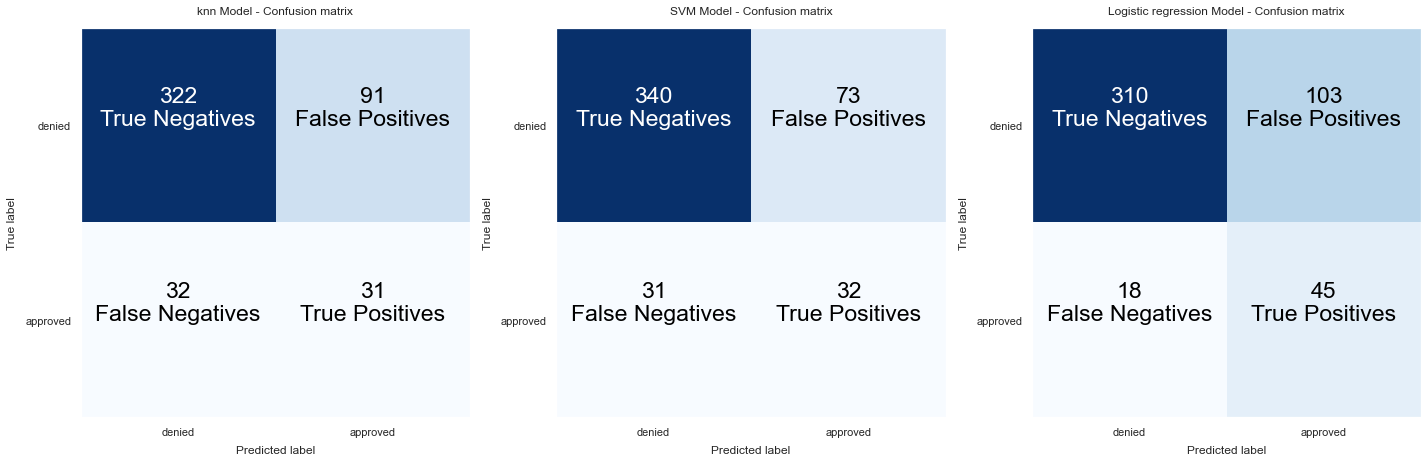

In [96]:
# Compute confusion matrix
cnf_matrix01 = confusion_matrix(y_test, y_pred03_new);
np.set_printoptions(precision=2);

class_names = ["denied", "approved"]

# Plot non-normalized confusion matrix
plt.figure(figsize=(20, 20))

plt.subplot(131)
plt.grid(False)
plot_confusion_matrix(cnf_matrix01, classes=class_names, title='knn Model - Confusion matrix')

# Compute confusion matrix
cnf_matrix02 = confusion_matrix(y_test, y_pred_grid);
np.set_printoptions(precision=2);

class_names = ["denied", "approved"]

# Plot non-normalized confusion matrix
plt.subplot(132)
plt.grid(False)
plot_confusion_matrix(cnf_matrix02, classes=class_names, title='SVM Model - Confusion matrix')

# Compute confusion matrix
cnf_matrix03 = confusion_matrix(y_test, y_pred_logit);
np.set_printoptions(precision=2);

class_names = ["denied", "approved"]

# Plot non-normalized confusion matrix
plt.subplot(133)
plt.grid(False)
plot_confusion_matrix(cnf_matrix03, classes=class_names, title='Logistic regression Model - Confusion matrix')


#### Summary:
1. For the results from the above confusion matrix, the models were used in the imbalanced dataset. The logistic regression model did better than the other two models, having the best roc_auc_score, Specificity, Precision, and F1 Score. The interpretation of logistic regression model confusion matrix is that out of of 63 no denied samples 45 were correctly predicted as approved by the model (true positives) and 18 were wrongly predicted as denied by the model (false negatives). And out of 413 denied samples, 310 were correctly predicted as denied by the model (true negatives) and 103 were wrongly predicted as approved by the model (false positives).

2. For the balanced dataset, the adjusted knn Model has the highest mean accuracy (0.86). The logistic regression model has the least mean accuracy (0.73).

3. Although the prediction is not as good as the SVM model and the logistic regression model, the knn model has the highest mean accuracy on the balanced dataset. **I'll choose the adjusted knn model as the best model to predict if the mortgage application will be denied in the balanced dataset.**

4. The adjusted knn model has 11 features. They are 'dir', 'lvr', 'ccs', 'mcs', 'IsBadCredit', 'IsDeniedMI', 'uria', 'IsAfricanAmerican', 'IsCondo', 'IsSingle', and 'IsSelf'. All p-values are less than .05, meaning that all features in the momdel are significant in determining the denied mortgage.

5. The adjusted knn model use the parameters of n_neighbors=1 and p=1 instead of the default parameters with n_neighbors=5 and p=2. 

***
### Step 9. Conclusion

#### Interpretation of the knn model using `SHAP`:

From the above steps, I've already got a best model (the knn model).

For the linear regression or logistic regression models, the coefficients can tell the influence of each feature on the final result. In contrast, the interpretation of the knn model is not clear. I'll use `SHAP` to calculate the feature importance in my final knn model. 

I'll call the explainer with `shap.KernelExplainer()`- a model agnostic method to estimate SHAP values for any model. This command produces an explanation model for the KNN classifier. It is very slow to use the whole training dataset, so (as recommended by the library) I'll use `shap.kmeans` to create 30 representative rows from the training set. Also, I'll use the explainer on first 50 samples of the training set. I should use the explainer on all samples of the training set, but it would be very slow and take hours to complete it. I can explain the predictions in either training or testing set but the explainer should be defined on the training set. In this case, I'll explain the training set.


In [122]:
import shap
# kernel explainer is slow so we use shap.kmeans(data,K) to accelerate its evaluation
# we set K=30 for fast illustration, larger value should be considered in the real case
# knn_explainer should be defined on the training set

knn_explainer = shap.KernelExplainer(best_model.predict, shap.kmeans(X03, 30))

n_explain = 50
# explain on the training set (first 50 samples)
shap_values = knn_explainer.shap_values(X03[:n_explain])


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


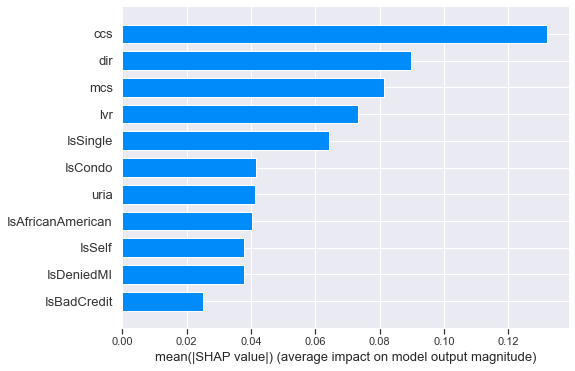

In [123]:
# Variable importance
shap.summary_plot(shap_values, X03, plot_type="bar")


**Conclusion:**

Based on the plot above, for the final knn model, the top 2 reasons that the mortgage applicantions will be denied are 'ccs' and 'dir', they are consumer credit score and debt payments to total income ratio. Next reasons are mortgage credit score (mcs), ratio of size of loan to assessed value of property (lvr), is single, is condo, unemployment rate (uria), is African American, is self employed, having denied mortgage insurance, and having public bad credit record (the least important). 

In this model, only the 'housing expenses to income ratio' feature was deleted since it cannot significantly predict the dependent variable and did not improve the model. It looks reasonable because housing expenses to income ratio is not as important as other features, especially for a condo since condo don't have as much expenses as a house does. Also, the mortgage pre-approval is maily based on the applicant's credit score, job (stable or not), and salay. Usually, when the applicant has a stable job with a decent salary, good cash flow for 20% down payment, and good credit score, mortgage applicantion would have a higher chance to get approved. 
